https://medium.com/@ellaceroni/shors-algorithm-unravelling-encryption-with-quantum-677e97144b5a#3524

https://arxiv.org/pdf/1903.00768.pdf

In [50]:
import pennylane as qml
import numpy as np
import math as math
from fractions import Fraction

In [51]:
n=4 #qft part
m=4 #modular exponentiation part

In [52]:
device = qml.device("qiskit.aer", wires=n+m, shots=2048)

In [53]:
def phaseShift(qml,k,n):
    qml.PhaseShift(-2*np.pi/2**k,wires=n)

def inverseQFT(qml,indexes):
    m = 0
    n = len(indexes)-1
    for _ in range(m,n):
        while m < n:
            qml.SWAP(wires=[indexes[m],indexes[n]])
            m += 1
            n -= 1

    n = len(indexes)-1

    qml.Hadamard(wires=indexes[n])
    controlledQubit = n-1
    for _ in range(n):
        k = (n-controlledQubit) + 1
        for j in range(n,controlledQubit,-1):
            qml.ctrl(phaseShift, control=indexes[controlledQubit])(qml,k,indexes[j])
        qml.Hadamard(wires=indexes[controlledQubit])
        controlledQubit -= 1

(<Figure size 1400x500 with 1 Axes>, <Axes: >)


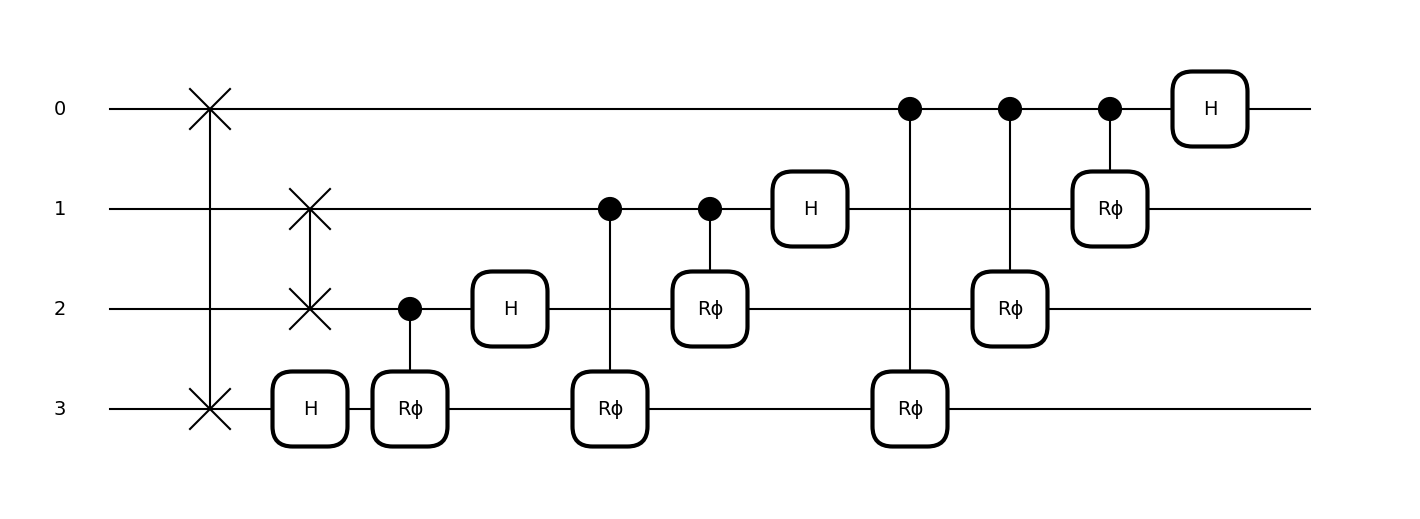

In [54]:
print(qml.draw_mpl(inverseQFT, wire_order=range(4))(qml,[0,1,2,3]))

In [55]:
def aMod15(qml,a,x, qubits):
    for _ in range(x):
        if a in [2,13]:
            qml.SWAP(wires=[qubits[0],qubits[1]])
            qml.SWAP(wires=[qubits[1],qubits[2]])
            qml.SWAP(wires=[qubits[2],qubits[3]])
        if a in [7,8]:
            qml.SWAP(wires=[qubits[2],qubits[3]])
            qml.SWAP(wires=[qubits[1],qubits[2]])
            qml.SWAP(wires=[qubits[0],qubits[1]])
        if a == 11:
            qml.SWAP(wires=[qubits[1],qubits[3]])
            qml.SWAP(wires=[qubits[0],qubits[2]])
        if a in [7,11,13]:
            for qubit in range(4):
                qml.PauliX(wires=qubits[qubit])

        if a == 4: # my test
            qml.SWAP(wires=[qubits[2],qubits[3]])
        if a == 14:
            for qubit in range(4):
                qml.PauliX(wires=qubits[qubit])

def modExp(qml,n,m,a):
    for x in range (n):
        qml.ctrl(aMod15, control=x)(qml,a, 2**x, range(n,n+m))

(<Figure size 400x100 with 1 Axes>, <Axes: >)


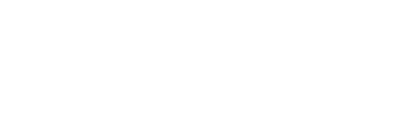

In [64]:
a=2
print(qml.draw_mpl(aMod15, wire_order=range(4))(qml,a,0,range(4)))

(<Figure size 6300x900 with 1 Axes>, <Axes: >)


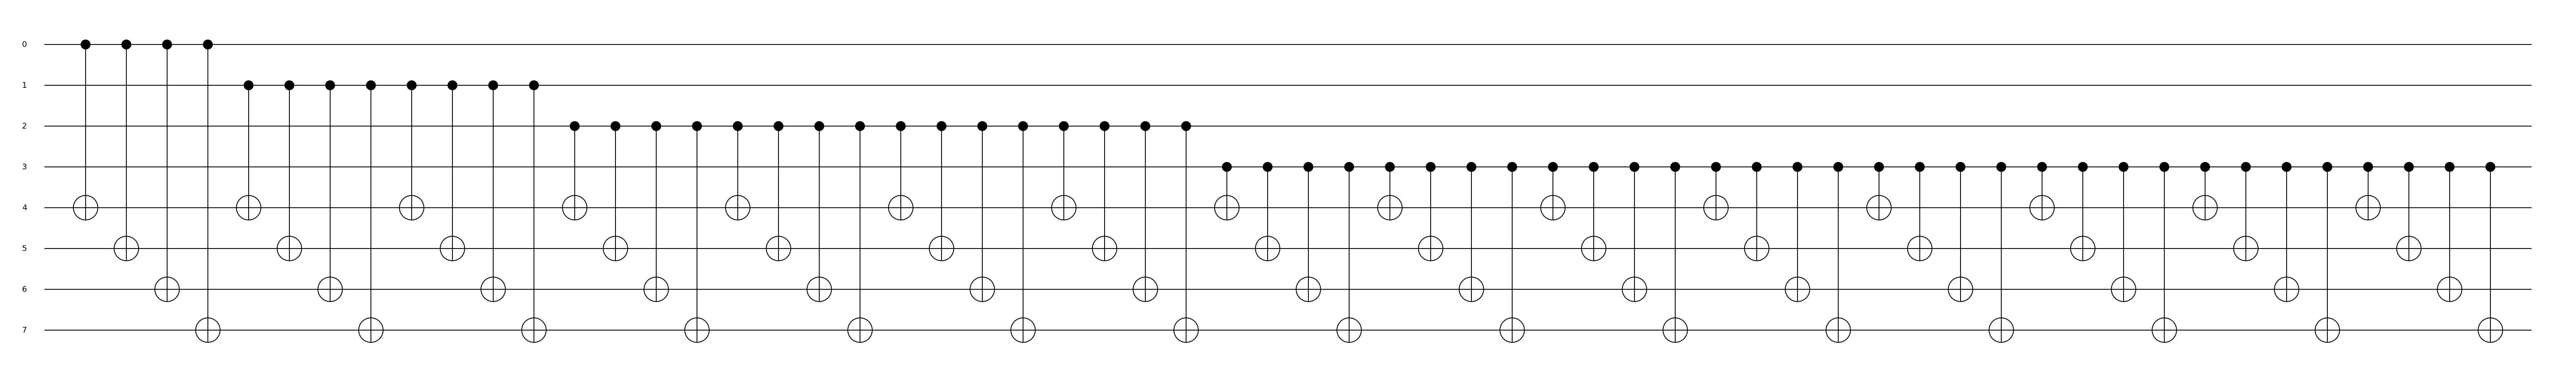

In [65]:
print (qml.draw_mpl(modExp, wire_order=range(8))(qml,4,4,14))

In [58]:
@qml.qnode(device)
def shor(n,m,a, returnCounts = False):
    for x in range(n):
        qml.Hadamard(wires=x)

    qml.PauliX(wires=n+m-1)

    modExp(qml,n,m,a)

    inverseQFT(qml,range(n))

    for x in range(n):
        qml.measure(wires=x)

    if returnCounts:
        return qml.counts(wires=range(n))
    else:
        return qml.sample(wires=range(n))

In [59]:
def processMeasurement(measurement,n):
    binaryString = ''.join(map(str, measurement))
    measuredInt = int(binaryString,2)
    phase = measuredInt/(2**n)
    f = Fraction.from_float(phase).limit_denominator(n)
    _,r = f.numerator, f.denominator
    print ("corresponding phase",phase," r ",r)
    return r, phase

In [60]:
N = 15 # number to factor

# note to myself 4,14 is bad, does not stop
coprime = False
while coprime == False:
    a = np.random.randint(2, N)
    if math.gcd(a,N) == 1: #and a in [2,7,8,11,13]:
        coprime = True

factorFound = False
attempts = 0
print ("trying with a=",a,"and N=",N)
while factorFound == False:
    attempts += 1
    counts = shor(n,m,a)
    r, phase = processMeasurement(counts[0],n)
    if phase != 0:
        guesses = [math.gcd(a**(r//2)-1,N), math.gcd(a**(r//2)+1,N)]
        print ("guesses",guesses)
        for guess in guesses:
            if guess not in [1,N] and N%guess == 0:
                factorFound = True
                print ("Found non trivial factors of",N,"; ",guess,"and",N//guess)
                break

trying with a= 7 and N= 15
corresponding phase 0.4375  r  2
guesses [3, 1]
Found non trivial factors of 15 ;  3 and 5


{'0000': 498, '0001': 439, '0010': 431, '0011': 210, '0101': 64, '0110': 63, '0111': 171, '1001': 20, '1010': 15, '1011': 26, '1101': 9, '1110': 11, '1111': 91}


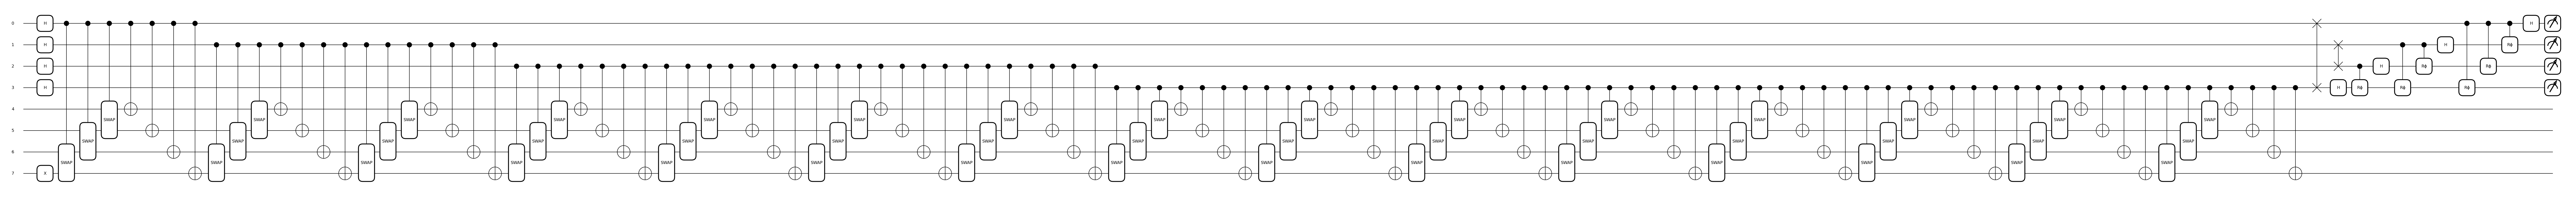

In [61]:
qml.draw_mpl(shor, wire_order=range(8))(n,m,a)

result = shor(n,m,a, returnCounts = True)

print(result)